In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [3]:
train = pd.read_csv(r'''C:\Users\Sandeep's\Desktop\Competitive Data Science\Machine Hack\Grocery Forecasting\Data\Train.csv''')
test = pd.read_csv(r'''C:\Users\Sandeep's\Desktop\Competitive Data Science\Machine Hack\Grocery Forecasting\Data\Test.csv''')
ss = pd.read_excel(r'''C:\Users\Sandeep's\Desktop\Competitive Data Science\Machine Hack\Grocery Forecasting\Data\Sample_Submission.xlsx''')

In [4]:
train.head()

,Day,GrocerySales
0,1,8418.59
1,2,8447.47
2,3,8336.49
3,4,8579.17
4,5,8524.31


In [5]:
test.head()

,Day
0,693
1,694
2,695
3,696
4,697


In [6]:
ss.head()

,GrocerySales
0,8606.187433
1,8973.760000
2,8946.170000
3,9138.900000
4,9012.110000


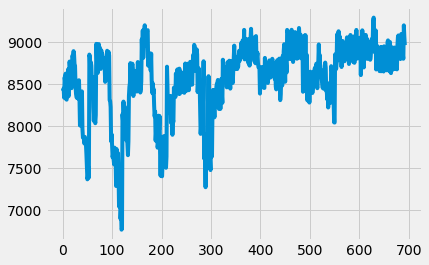

In [7]:
plt.plot(train['Day'],train['GrocerySales'])
plt.show()

# SARIMAX

In [8]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 1) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 1)
SARIMAX: (0, 0, 1) x (0, 0, 2, 1)
SARIMAX: (0, 0, 2) x (0, 1, 0, 1)
SARIMAX: (0, 0, 2) x (0, 1, 1, 1)


In [ ]:
y = train.GrocerySales
minimum = np.inf
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            if results.aic < minimum:
                print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
                minimum = results.aic
                
#             print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 1) - AIC:14479.31107038289
ARIMA(0, 0, 0)x(0, 0, 1, 1) - AIC:13953.665393271025
ARIMA(0, 0, 0)x(0, 0, 2, 1) - AIC:12743.437267333235
ARIMA(0, 0, 0)x(0, 1, 0, 1) - AIC:9408.685924252713
ARIMA(0, 0, 0)x(0, 1, 1, 1) - AIC:9301.590703739175
ARIMA(0, 0, 0)x(0, 1, 2, 1) - AIC:9286.60082361859
ARIMA(0, 0, 1)x(0, 1, 2, 1) - AIC:9276.085853290693
ARIMA(0, 0, 1)x(0, 2, 2, 1) - AIC:9270.090173697849
ARIMA(0, 0, 2)x(0, 1, 2, 1) - AIC:9266.622760966939
ARIMA(0, 0, 2)x(0, 2, 2, 1) - AIC:9257.82854658296


In [9]:
y = train.GrocerySales
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 0, 2),
                                seasonal_order=(0, 2, 2, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4634    117.358     -0.004      0.997    -230.482     229.555
ma.L2         -0.0402     63.192     -0.001      0.999    -123.894     123.814
ma.S.L1       -0.9248    117.353     -0.008      0.994    -230.933     229.083
ma.S.L2       -0.0752    117.360     -0.001      0.999    -230.096     229.946
sigma2      4.235e+04      0.009   4.56e+06      0.000    4.23e+04    4.23e+04


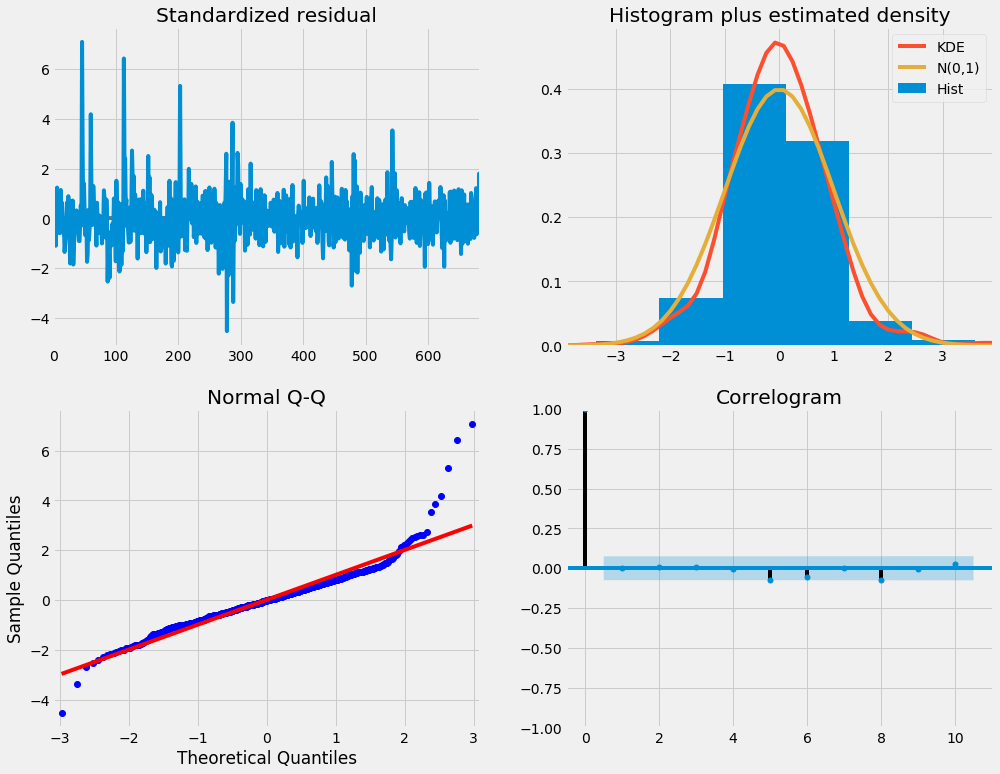

In [10]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

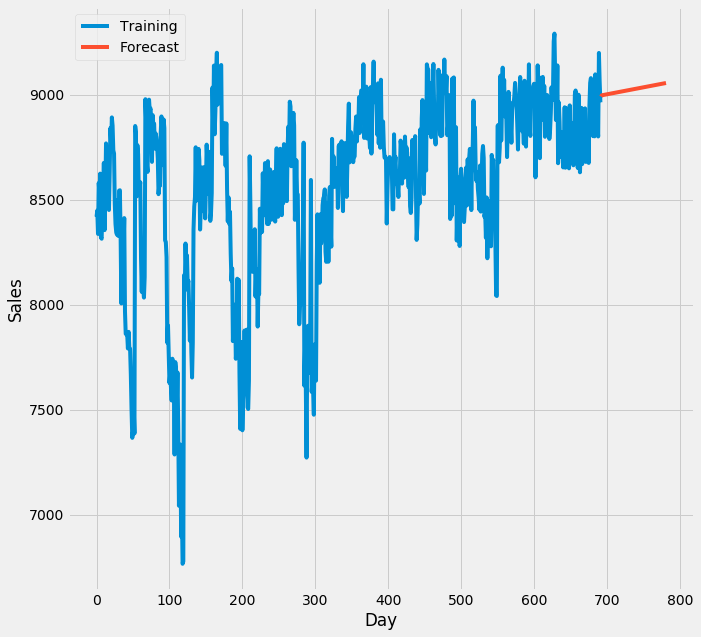

In [19]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=90)

# # Get confidence intervals of forecasts
# pred_ci = pred_uc.conf_int()

plt.figure(figsize=(10,10))
plt.plot(range(692), y,label='Training')
plt.plot(range(692,692+90), pred_uc.predicted_mean.values,label = 'Forecast')
plt.legend()
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Day')
plt.ylabel('Sales')
plt.show()

In [22]:
test_predictions = pred_uc.predicted_mean.values
test_xlsx = pd.DataFrame(test_predictions,columns = ['GrocerySales'])

In [26]:
test_xlsx.to_excel('Submission_1.xlsx',index=False)